# Setup Environment

If you are working on this assignment using Google Colab, please execute the codes below.

Alternatively, you can also do this assignment using a local anaconda environment (or a Python virtualenv). Please clone the GitHub repo by running `git clone https://github.com/Berkeley-CS182/cs182hw2.git` and refer to `README.md` for further details.

In [1]:
# #@title Mount your Google Drive

# import os
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# #@title Set up mount symlink

# DRIVE_PATH = '/content/gdrive/My\ Drive/cs182hw2_sp25'
# DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
# if not os.path.exists(DRIVE_PYTHON_PATH):
#   %mkdir $DRIVE_PATH

# ## the space in `My Drive` causes some issues,
# ## make a symlink to avoid this
# SYM_PATH = '/content/cs182hw2'
# if not os.path.exists(SYM_PATH):
#   !ln -s $DRIVE_PATH $SYM_PATH

In [1]:
#@title Install dependencies
!pip install --no-deps --upgrade IPython
import matplotlib
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# #@title Clone homework repo

# %cd $SYM_PATH
# !git clone https://github.com/Berkeley-CS182/cs182sp25_public.git
# %cd cs182sp25_public/hw02/q_coding_optimizer_init/code

In [3]:
# #@title Download datasets

# %cd deeplearning/datasets/
# !bash ./get_datasets_curl.sh
# %cd ../..

In [4]:
#@title Configure Jupyter Notebook

# Optimization Methods and Initizalization

Until now, you've always used Gradient Descent to update the parameters and minimize the cost. In this notebook, you will learn more advanced optimization methods that can speed up learning and perhaps even get you to a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result. 

Gradient descent goes "downhill" on a cost function $J$. Think of it as trying to do this: 
<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C2%20-%20Improving%20Deep%20Neural%20Networks%20Hyperparameter%20tuning%2C%20Regularization%20and%20Optimization/Week%202/images/cost.jpg">
<caption><center> <u> <strong>Figure 1</strong> </u>: <strong>Minimizing the cost is like finding the lowest point in a hilly landscape<strong/><br> At each step of the training, you update your parameters following a certain direction to try to get to the lowest possible point. </center></caption>


In [5]:
# As usual, a bit of setup

import os
import json
import time
import numpy as np

import matplotlib.pyplot as plt
from deeplearning.classifiers.fc_net import *
from deeplearning.data_utils import get_CIFAR10_data
from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.solver import Solver
import random 
import torch
seed = 7
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [6]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

deeplearning/datasets/cifar-10-batches-py/data_batch_1
deeplearning/datasets/cifar-10-batches-py/data_batch_2
deeplearning/datasets/cifar-10-batches-py/data_batch_3
deeplearning/datasets/cifar-10-batches-py/data_batch_4
deeplearning/datasets/cifar-10-batches-py/data_batch_5
deeplearning/datasets/cifar-10-batches-py/test_batch
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## 1 - Stochastic Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent. 

A variant of this is Stochastic Gradient Descent (SGD), which is equivalent to mini-batch gradient descent where each mini-batch has just 1 example. The update rule that you have just implemented does not change. What changes is that you would be computing gradients on just one training example at a time, rather than on the whole training set. The code examples below illustrate the difference between stochastic gradient descent and (batch) gradient descent. 

In Stochastic Gradient Descent, you use only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly. Here is an illustration of this: 

<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C2%20-%20Improving%20Deep%20Neural%20Networks%20Hyperparameter%20tuning%2C%20Regularization%20and%20Optimization/Week%202/images/kiank_sgd.png">
<caption><center> <u>  <strong>Figure 1</strong> </u> : <strong>SGD vs GD</strong><br> "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence. But each step is a lot faster to compute for SGD than for GD, as it uses only one training example (vs. the whole batch for GD). </center></caption>

In the following code snippet, we will use SGD to optimze a five-layer FullyConnectedNet so that it overfits to 50 training exmaples. 

(Iteration 1 / 40) loss: 94.233583
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.123000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.102000
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.118000
(Epoch 3 / 20) train acc: 0.480000; val_acc: 0.133000
(Epoch 4 / 20) train acc: 0.720000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.800000; val_acc: 0.105000
(Iteration 11 / 40) loss: 1.410664
(Epoch 6 / 20) train acc: 0.940000; val_acc: 0.108000
(Epoch 7 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.113000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.116000
(Iteration 21 / 40) loss: 0.000076
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.116000


/Users/nico/cs182/cs182fa25_public/hw02/code/deeplearning/layers.py:153: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.116000
(Iteration 31 / 40) loss: 0.000327
(Epoch 16 / 20) train acc: 1.000000; val_acc: 0.115000
(Epoch 17 / 20) train acc: 1.000000; val_acc: 0.115000
(Epoch 18 / 20) train acc: 1.000000; val_acc: 0.115000
(Epoch 19 / 20) train acc: 1.000000; val_acc: 0.115000
(Epoch 20 / 20) train acc: 1.000000; val_acc: 0.115000


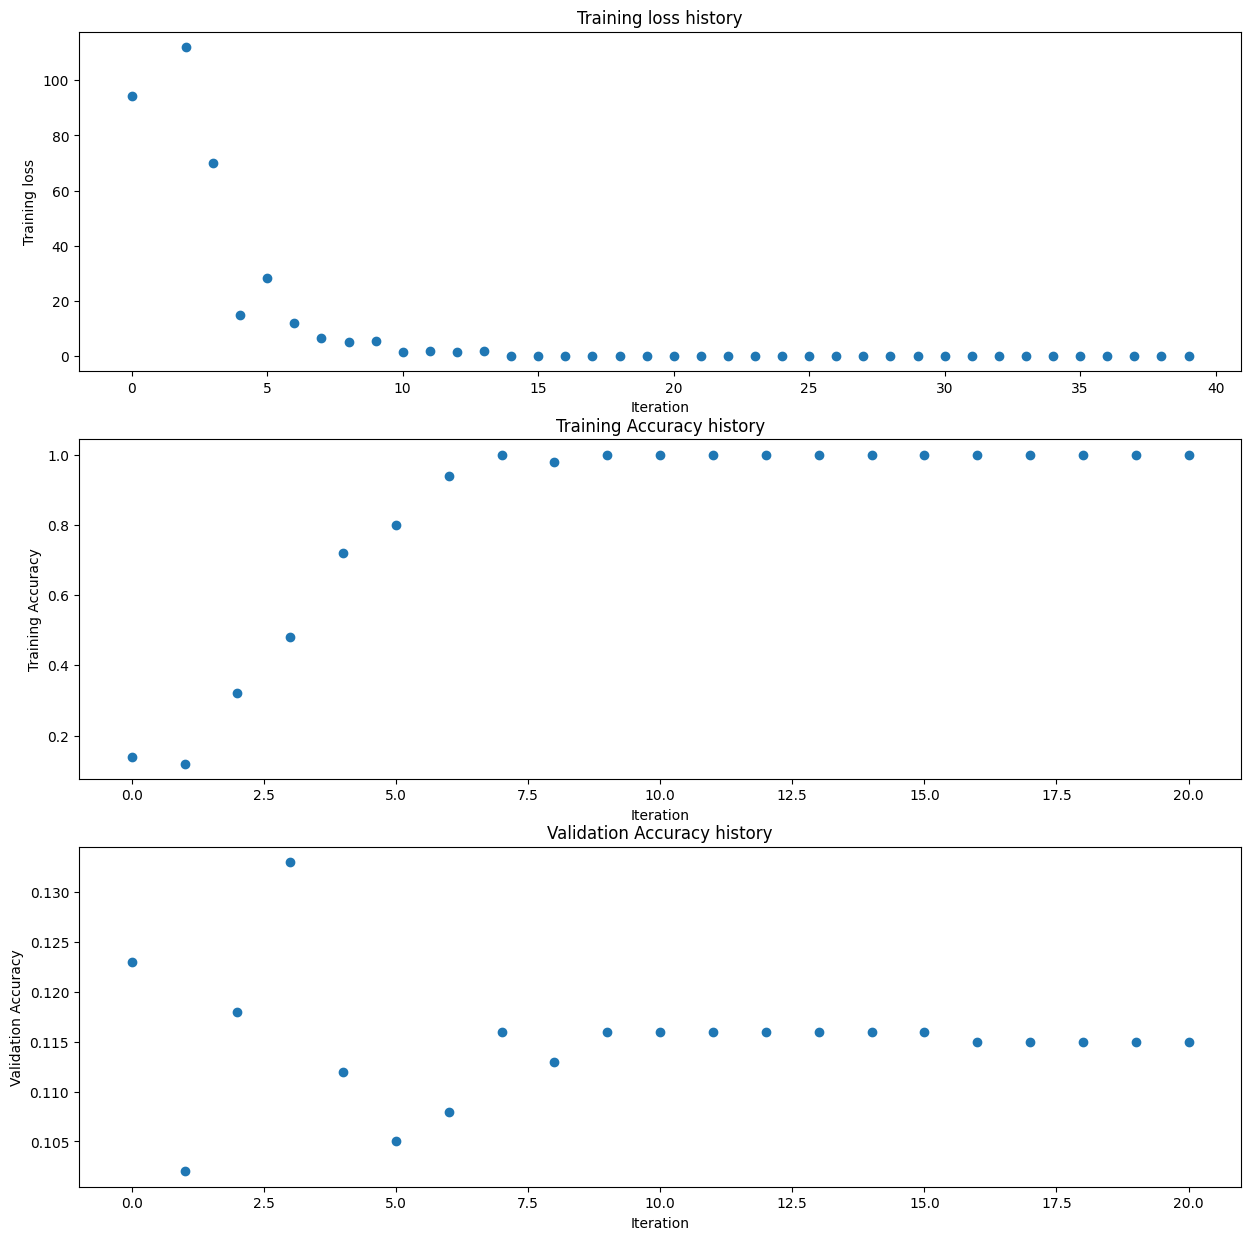

In [7]:
## Use a five-layer Net to overfit 50 training examples.
 

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1
learning_rate = 1e-3
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)

solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, 'o')
plt.title('Training Accuracy history')
plt.xlabel('Iteration')
plt.ylabel('Training Accuracy')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, 'o')
plt.title('Validation Accuracy history')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.gcf().set_size_inches(15, 15)

plt.show()

## 2 - Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations. 

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill. 

<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C2%20-%20Improving%20Deep%20Neural%20Networks%20Hyperparameter%20tuning%2C%20Regularization%20and%20Optimization/Week%202/images/opt_momentum.png">
<caption><center> <u><strong>Figure 3</strong></u>: The red arrows shows the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, we let the gradient influence v (velocity) and then take a step in the direction of v.<br> </center>

 The momentum update rule for a weight matrix w is: 

$$ \begin{cases}
v_{dw}^t = m * v_{dw}^{(t-1)} + dw\\
{w} = w - \alpha  v_{dw}^t
\end{cases}\tag{3}$$


where $m$ is the momentum and $\alpha$ is the learning rate. Note that the iterator `t` starts at 1. 

Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent, it can be viewed conceptually a larger "effective batch size" versus vanilla stochastic gradient descent. 

Open the file `deeplearning/optim.py` and read the documentation at the top of the file to make sure you understand the API. **Implement the SGD+momentum update rule** in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-7.

In [8]:
from deeplearning.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
 [-0.39994, -0.347375263, -0.294810526, -0.242245789, -0.189681053], 
 [-0.137116316, -0.084551579, -0.031986842, 0.020577895, 0.073142632], 
 [0.125707368, 0.178272105, 0.230836842, 0.283401579, 0.335966316], 
 [0.388531053, 0.441095789, 0.493660526, 0.546225263, 0.59879]])
expected_velocity = np.asarray([
 [-0.06, 0.006842105, 0.073684211, 0.140526316, 0.207368421], 
 [0.274210526, 0.341052632, 0.407894737, 0.474736842, 0.541578947], 
 [0.608421053, 0.675263158, 0.742105263, 0.808947368, 0.875789474], 
 [0.942631579, 1.009473684, 1.076315789, 1.143157895, 1.21]
])

print ('next_w error: ', rel_error(next_w, expected_next_w))
print ('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  6.3941900171621575e-09
velocity error:  1.923077600561035e-08


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge a bit faster.

running with  sgd
(Iteration 1 / 200) loss: 2.859678
(Epoch 0 / 5) train acc: 0.097000; val_acc: 0.091000
(Iteration 11 / 200) loss: 2.108301
(Iteration 21 / 200) loss: 2.054190
(Iteration 31 / 200) loss: 2.032130
(Epoch 1 / 5) train acc: 0.256000; val_acc: 0.280000
(Iteration 41 / 200) loss: 2.002000
(Iteration 51 / 200) loss: 1.980703
(Iteration 61 / 200) loss: 1.858749
(Iteration 71 / 200) loss: 1.971338
(Epoch 2 / 5) train acc: 0.309000; val_acc: 0.267000
(Iteration 81 / 200) loss: 2.084705
(Iteration 91 / 200) loss: 1.726726
(Iteration 101 / 200) loss: 1.753505
(Iteration 111 / 200) loss: 1.846681
(Epoch 3 / 5) train acc: 0.368000; val_acc: 0.307000
(Iteration 121 / 200) loss: 1.794569
(Iteration 131 / 200) loss: 1.798595
(Iteration 141 / 200) loss: 1.789055
(Iteration 151 / 200) loss: 1.759879
(Epoch 4 / 5) train acc: 0.400000; val_acc: 0.319000
(Iteration 161 / 200) loss: 1.786746
(Iteration 171 / 200) loss: 1.713384
(Iteration 181 / 200) loss: 1.867161
(Iteration 191 / 200) los

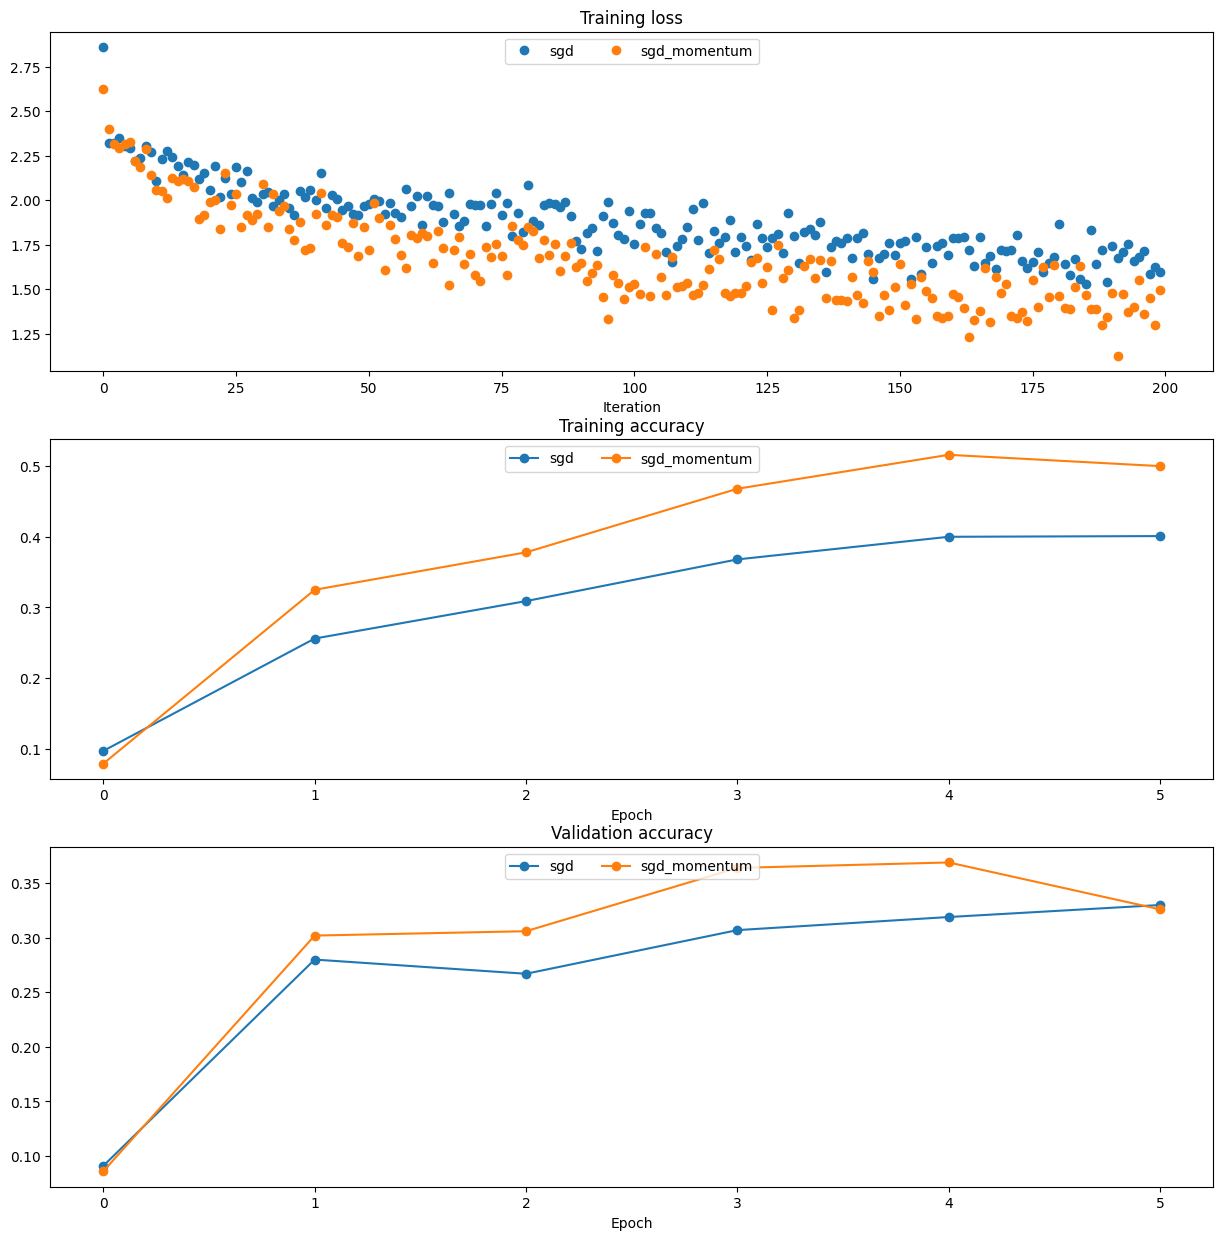

In [9]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print ('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    os.makedirs("submission_logs", exist_ok=True)
    solver.record_histories_as_npz("submission_logs/optimizer_experiment_{}".format(update_rule))
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

A further step: as we discussed above, we can see how SGD+Momentum is conceptually giving you a larger "effective batch size" by increase the batch size used in the SGD above. In this way, SGD+Momentum can significantly speed up training.

**Tune the batch size for plain SGD** so that the training accuracy is similar to that of SGD with momentum. The average accuracy difference between them should be less than `0.04`. The accuracy is averaged over three different random seeds for better stability.

running with sgd  ; seed = 7
(Iteration 1 / 300) loss: 2.566251
(Epoch 0 / 10) train acc: 0.099000; val_acc: 0.091000
(Iteration 11 / 300) loss: 2.168396
(Iteration 21 / 300) loss: 2.155950
(Epoch 1 / 10) train acc: 0.257000; val_acc: 0.252000
(Iteration 31 / 300) loss: 2.009083
(Iteration 41 / 300) loss: 1.966240
(Iteration 51 / 300) loss: 2.000589
(Epoch 2 / 10) train acc: 0.294000; val_acc: 0.298000
(Iteration 61 / 300) loss: 1.872201
(Iteration 71 / 300) loss: 1.945993
(Iteration 81 / 300) loss: 1.889613
(Epoch 3 / 10) train acc: 0.333000; val_acc: 0.315000
(Iteration 91 / 300) loss: 1.972462
(Iteration 101 / 300) loss: 1.936928
(Iteration 111 / 300) loss: 1.836746
(Epoch 4 / 10) train acc: 0.366000; val_acc: 0.326000
(Iteration 121 / 300) loss: 1.861047
(Iteration 131 / 300) loss: 1.763051
(Iteration 141 / 300) loss: 1.818861
(Epoch 5 / 10) train acc: 0.367000; val_acc: 0.313000
(Iteration 151 / 300) loss: 1.793532
(Iteration 161 / 300) loss: 1.725085
(Iteration 171 / 300) loss: 1

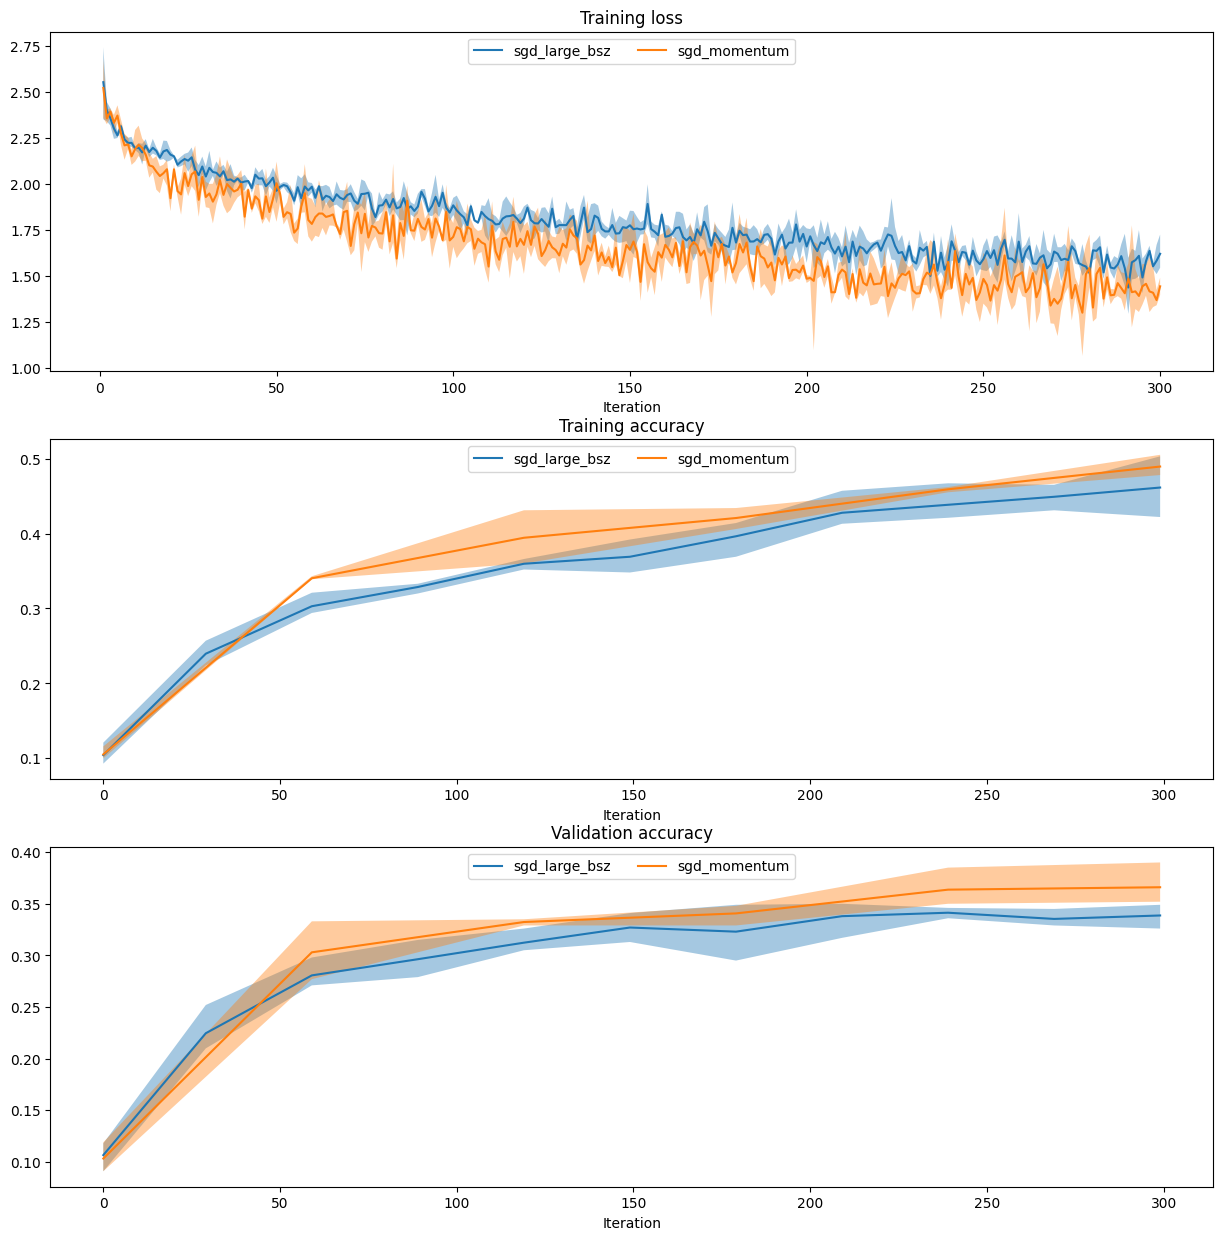

In [10]:
#############################################################################
# TODO: Tune the batch size for the SGD below until you observe             #
# similar end of iteration training performance.                            #
# It means rel_error(train_acc) < 0.04                                      #
#############################################################################
batch_sizes = {
  'sgd_momentum': 100,
  'sgd': 200,  # tune the batch size of SGD (must be multiples of 100)
}

num_train = 6000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
total_acc = {}

labels = {
  'sgd_momentum': 'sgd_momentum',
  'sgd': 'sgd_large_bsz',
}

for update_rule in ['sgd', 'sgd_momentum']:
    print ('running with', update_rule, ' ; seed =', seed)
    # set the epochs so that we have the same number of steps for both rules
    training_epochs = 5 * int(batch_sizes[update_rule]/100)
    solvers[update_rule] = {}
    total_acc[update_rule] = 0

    for seed in [100, 200, 300]:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

        solver = Solver(
            model, small_data,
            num_epochs=training_epochs,
            batch_size=batch_sizes[update_rule],
            update_rule=update_rule,
            optim_config={
                'learning_rate': 1e-2,  # please do not change the learning rate
            },
            verbose=True,
            log_acc_iteration=True)
        
        solvers[update_rule][seed] = solver
        solver.train()
        solver.record_histories_as_npz(
            "submission_logs/sgd_momentum_compare_{}_{}"
            .format(update_rule, seed)
        )

        total_acc[update_rule] += solvers[update_rule][seed].train_acc_history[-1]

print('Average Training Acc for sgd:', total_acc['sgd'] / 3)
print('Average Training Acc for sgd_momentum:', total_acc['sgd_momentum'] / 3)
print('Train Acc Difference: ',
       rel_error(total_acc['sgd'] / 3,
                 total_acc['sgd_momentum'] / 3))

def plot_solver_seeds(solver_s, x_field, y_field, seeds, label):
    a = np.array([getattr(solver_s[seed], y_field) for seed in seeds])
    if x_field is None:
        plt_x = np.arange(a.shape[1]) + 1
    else:
        plt_x = getattr(solver_s[seeds[0]], x_field)
    plt.plot(plt_x, a.mean(axis=0), label=label)
    plt.fill_between(plt_x, a.min(axis=0), a.max(axis=0), alpha=0.4)

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Iteration')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Iteration')

for update_rule, solver_s in solvers.items():
    plt.subplot(3, 1, 1)
    # plt.plot(solver.loss_history, 'o', label=labels[update_rule])
    plot_solver_seeds(solver_s, None, 'loss_history',
                      [100, 200, 300], labels[update_rule])

    plt.subplot(3, 1, 2)
    # plt.plot(solver.log_acc_iteration_history, solver.train_acc_history, '-o', label=labels[update_rule])
    plot_solver_seeds(solver_s, 'log_acc_iteration_history', 'train_acc_history',
                      [100, 200, 300], labels[update_rule])

    plt.subplot(3, 1, 3)
    # plt.plot(solver.log_acc_iteration_history, solver.val_acc_history, '-o', label=labels[update_rule])
    plot_solver_seeds(solver_s, 'log_acc_iteration_history', 'val_acc_history',
                      [100, 200, 300], labels[update_rule])

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## 3 - RMSProp (Optional)
As we saw with the "Implicit Regularization" example in lecture, using one fixed learning rate will cause the optimizer to converge more slowly in some parameters than in others. This may not be ideal since we need to set the learning rate small so that parameters that change quickly don't diverge, but parameters that change more slowly may need larger learning rates to converge quickly. RMSProp is an **adaptive** algorithm, which adapts the learning rate of each parameter individually in order to help all parameters converge at similar speed to each other. 

RMSProp works by keeping an exponentially weighted moving average of the squared partial derivatives of the loss with respect each parameter, which serves as an estimate to how quickly that parameter is changing. RMSProp then scales the gradient of each component by the square root of this moving average, such that the gradients with respect to each parameter are (approximately) equal.

The RMSPRop update rule is as follows:

$$\begin{cases}
r = \rho r + (1 - \rho) (\frac{\partial \mathcal{J} }{\partial W })^2 \\
w = w - \alpha \frac{1}{\sqrt{r} + \varepsilon} \frac{\partial \mathcal{J} }{\partial W }
\end{cases}$$
where:
- $\rho$ is the "decay rate" that controls the exponentially weighted average. 
- $\alpha$ is the learning rate.
- $\varepsilon$ is a very small number to avoid dividing by zero.

In the file `deeplearning/optim.py`, implement the RMSProp update rule in the `rmsprop` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).


In [11]:
# Test RMSProp implementation; you should see errors less than 1e-7.
from deeplearning.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


## 4 - Adam
Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum. 

<strong>How does Adam work?</strong>
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $m$ (before bias correction) and $m^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from both $m^{corrected}$ and $v^{corrected}$.

$$\huge\begin{cases}
m_{dw} = \beta_1 m_{dw} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W } \\
m^{corrected}_{dw} = \frac{m_{dw}}{1 - (\beta_1)^t} \\
v_{dw} = \beta_2 v_{dw} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W })^2 \\
v^{corrected}_{dw} = \frac{v_{dw}}{1 - (\beta_2)^t} \\
w = w - \alpha \frac{m^{corrected}_{dw}}{\sqrt{v^{corrected}_{dw}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero


In the file `deeplearning/optim.py`, implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [20]:
# Test Adam implementation; you should see errors around 1e-7 or less.
from deeplearning.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])
expected_t = 6

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('v error: ', rel_error(expected_v, config['v']))
print ('m error: ', rel_error(expected_m, config['m']))
print ('t error: ', rel_error(expected_t, config['t']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09
t error:  0.0


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules. As a sanity check, you should see that RMSProp and Adam typically obtain at least 45% training accuracy within 5 epochs.

running with  sgd
(Iteration 1 / 200) loss: 2.920601
(Epoch 0 / 5) train acc: 0.095000; val_acc: 0.106000
(Iteration 11 / 200) loss: 2.259419
(Iteration 21 / 200) loss: 2.259472
(Iteration 31 / 200) loss: 2.111666
(Epoch 1 / 5) train acc: 0.265000; val_acc: 0.249000
(Iteration 41 / 200) loss: 2.049079
(Iteration 51 / 200) loss: 2.008793
(Iteration 61 / 200) loss: 1.969929
(Iteration 71 / 200) loss: 2.015482
(Epoch 2 / 5) train acc: 0.342000; val_acc: 0.323000
(Iteration 81 / 200) loss: 1.877204
(Iteration 91 / 200) loss: 1.746421
(Iteration 101 / 200) loss: 1.820583
(Iteration 111 / 200) loss: 1.814485
(Epoch 3 / 5) train acc: 0.343000; val_acc: 0.315000
(Iteration 121 / 200) loss: 1.839074
(Iteration 131 / 200) loss: 1.712923
(Iteration 141 / 200) loss: 1.834413
(Iteration 151 / 200) loss: 1.771377
(Epoch 4 / 5) train acc: 0.431000; val_acc: 0.332000
(Iteration 161 / 200) loss: 1.707295
(Iteration 171 / 200) loss: 1.539644
(Iteration 181 / 200) loss: 1.492332
(Iteration 191 / 200) los

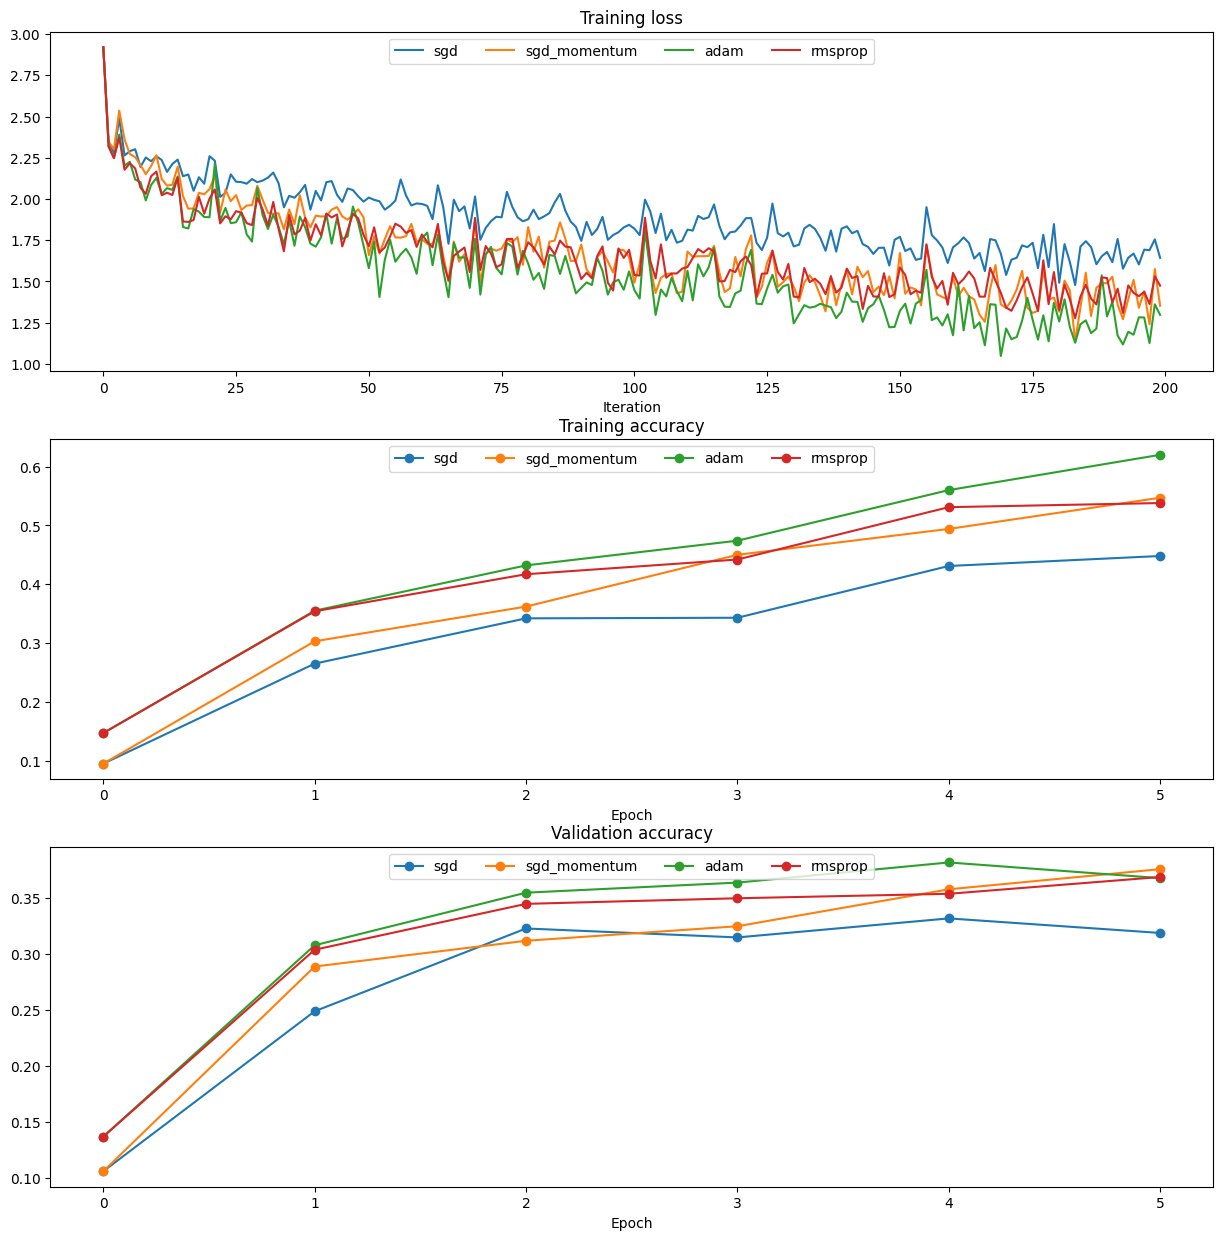

In [21]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3, 'sgd': 1e-2, 'sgd_momentum': 1e-2}
for update_rule in ['sgd', 'sgd_momentum', 'adam', 'rmsprop']:
    print ('running with ', update_rule)

    torch.manual_seed(0)
    np.random.seed(0)

    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True,)
    solvers[update_rule] = solver
    solver.train()
    solver.record_histories_as_npz("submission_logs/optimizer_experiment_{}".format(update_rule))
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Initialization

Training your neural network requires specifying an initial value of the weights. A well chosen initialization method will help learning.  


A well chosen initialization can:
- Speed up the convergence of gradient descent
- Increase the odds of gradient descent converging to a lower training (and generalization) error 

We will use three different initilization methods to illustrate this concept. 

- Zero Initialization:

    This initializes the weights to 0. 


- Random Initialization:

    This initializes the weights drawn from a distribution with *manually* specified scales. In this homework, **we use normal distribution with the `weight_scale` argument in `fc_net.py` as its std.** 

- He/Xavier/Glorot Initialization: 

    This is a special case for random initialization, where the scaling factor is set so that the std of each parameter is `gain / sqrt(fan_mode)`. `gain` is determined by the activation function. For example, linear activation has `gain = 1` and ReLU activation has `gain = sqrt(2)`. There are three types of fan mode:
    - Fan in: `fan_mode = in_dim`, i.e., the width of the preceding layer, preserving the magnitude in forward pass. **This is what you need to implement below** and also the default in PyTorch.
    - Fan out: `fan_mode = out_dim`, i.e., the width of the succeeding layer, preserving the magnitude in backpropagation.
    - Average: `fan_mode = (in_dim + out_dim) / 2`. 

    When the std is determined, another choice is between normal distribution or uniform distribution. In this homework **we use normal distribution for initialization.**

running with  sgd
initialization scheme: he
Layer 1, rel_error 0.00035971152920217424
Layer 2, rel_error 0.01631330765346264
(Iteration 1 / 200) loss: inf
(Epoch 0 / 5) train acc: 0.132000; val_acc: 0.127000
(Iteration 11 / 200) loss: 7.285763
(Iteration 21 / 200) loss: 3.930818
(Iteration 31 / 200) loss: 3.173336
(Epoch 1 / 5) train acc: 0.138000; val_acc: 0.103000
(Iteration 41 / 200) loss: 2.807061
(Iteration 51 / 200) loss: 2.523193
(Iteration 61 / 200) loss: 2.556054
(Iteration 71 / 200) loss: 2.713087
(Epoch 2 / 5) train acc: 0.170000; val_acc: 0.129000
(Iteration 81 / 200) loss: 2.430453
(Iteration 91 / 200) loss: 2.377073
(Iteration 101 / 200) loss: 2.224177
(Iteration 111 / 200) loss: 2.234489
(Epoch 3 / 5) train acc: 0.212000; val_acc: 0.166000
(Iteration 121 / 200) loss: 2.144483
(Iteration 131 / 200) loss: 2.167716
(Iteration 141 / 200) loss: 2.072116
(Iteration 151 / 200) loss: 2.239287
(Epoch 4 / 5) train acc: 0.194000; val_acc: 0.166000
(Iteration 161 / 200) loss: 2.2166

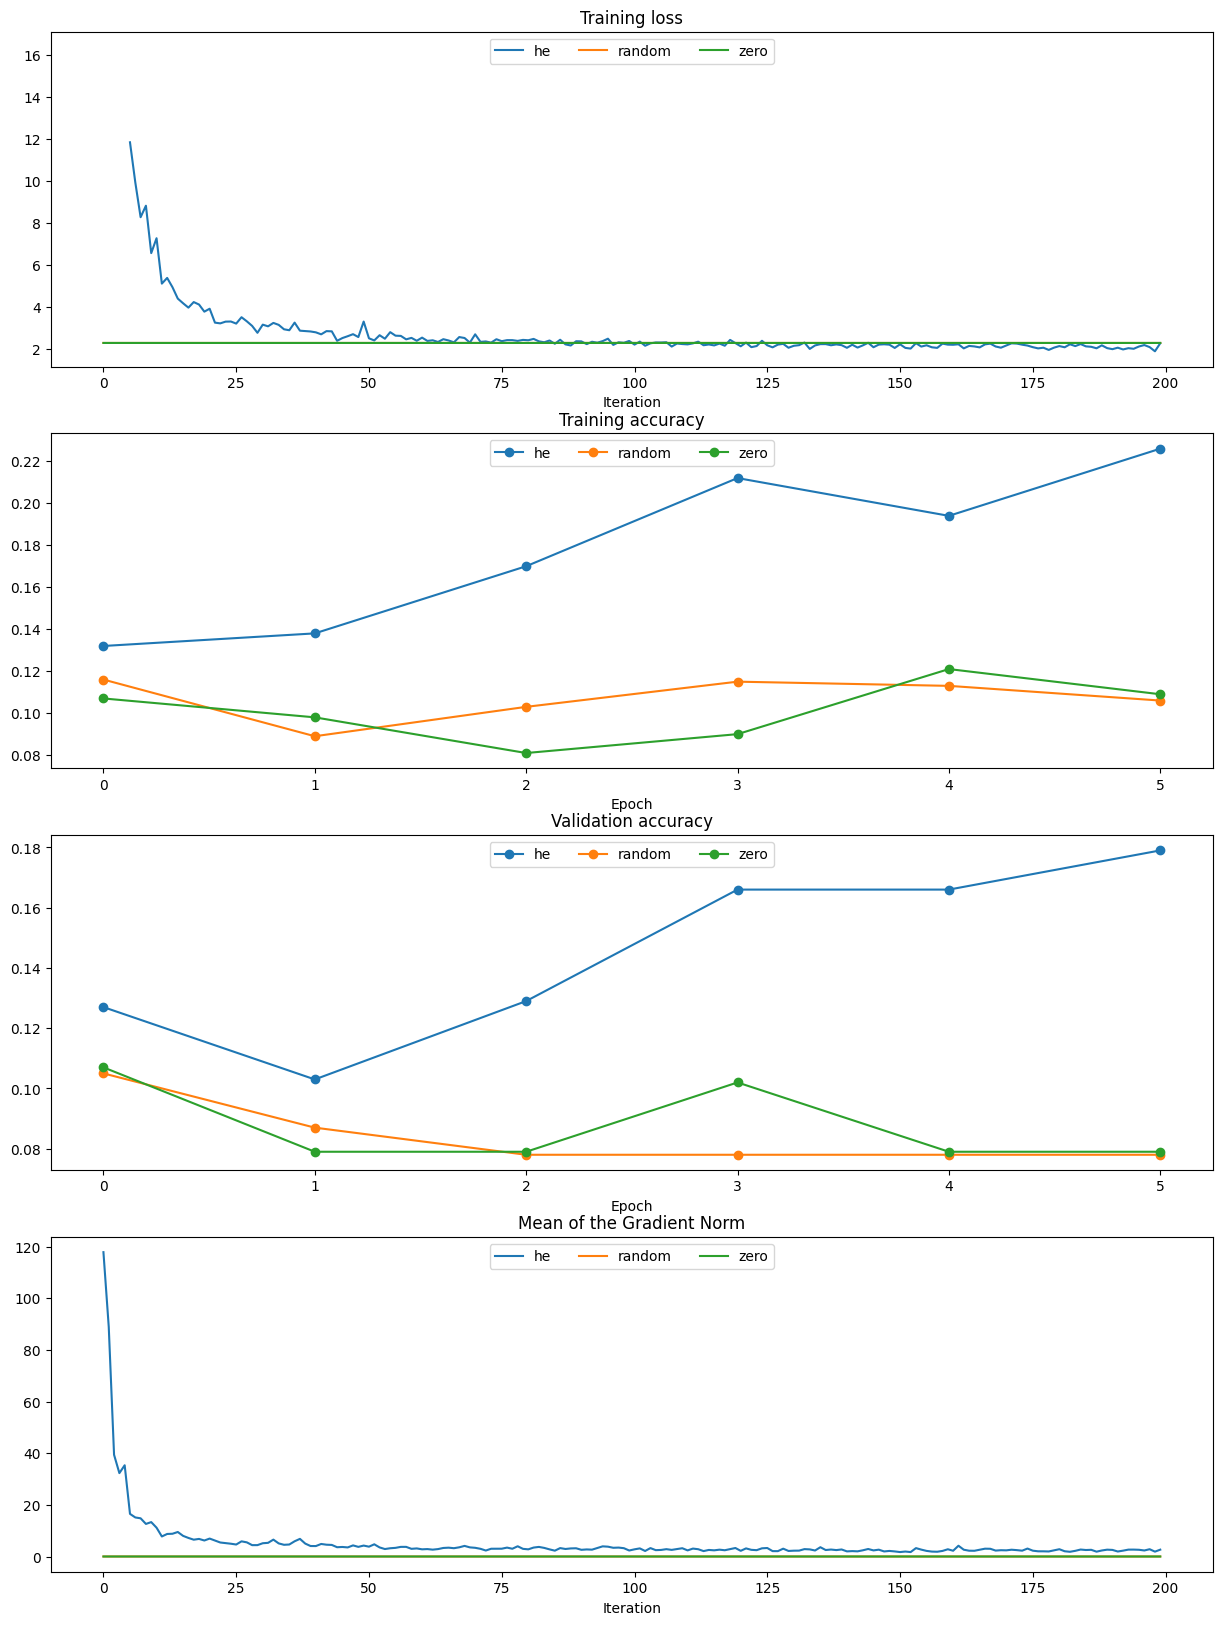

In [44]:
#############################################################################
# TODO:
# 1. implement the last two initialization schemes in
#    deeplearning/classifiers/fc_net.py
# 2. record the mean of l2 norm of the gradients                         
#    in the deeplearning/solver.py                                            
#############################################################################

learning_rates = {'sgd': 1e-3}
update_rule = 'sgd'
solvers = dict()

num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

for initialization in ['he', 'random', 'zero']:
    print ('running with ', update_rule)

    model = FullyConnectedNet([50]*10, initialization=initialization)
    weight_stds = [float(model.params["W" + str(i)].std()) for i in range(1, 12)]
    print("initialization scheme:", initialization)
    if initialization == "he":
        # It is fine if the rel_error is less than 0.03 due to randomness
        print("Layer 1, rel_error", rel_error(0.02551551815399, weight_stds[0]))
        print("Layer 2, rel_error", rel_error(0.2, weight_stds[1]))
    elif initialization == "random":
        # It is fine if the rel_error is less than 0.03 due to randomness
        print("Layer 1, rel_error", rel_error(0.01, weight_stds[0]))
        print("Layer 2, rel_error", rel_error(0.01, weight_stds[1]))
    with open("submission_logs/w_stds_{}.json".format(initialization), "w", encoding="utf-8") as f:
        json.dump(weight_stds, f)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
    solvers[initialization] = solver
    solver.train()
    solver.record_histories_as_npz("submission_logs/initialization_experiment_{}".format(initialization))
    print

plt.subplot(4, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')


plt.subplot(4, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 4)
plt.title('Mean of the Gradient Norm')
plt.xlabel('Iteration')

for initialization, solver in solvers.items():
    plt.subplot(4, 1, 1)
    plt.plot(solver.loss_history, label=initialization)

    plt.subplot(4, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=initialization)

    plt.subplot(4, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=initialization)

    plt.subplot(4, 1, 4)
    plt.plot(solver.log_grad_norm_history, label=initialization)

for i in [1, 2, 3, 4]:
    plt.subplot(4, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 20)

plt.show()

### Question:

**What you observe in the mean of gradient norm plot above in the above plots?** Try to give an explanation. **Write your answer on the written assignment.**

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable and the solver used in the `best_solver` variable. We require you to get at least 45% accuracy *on the validation set* using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

In [61]:
best_model = None
best_solver = None


width = 200  # please don't change this
n_layers = 10  # please don't change this

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10.             #
# Store your best model in the best_model variable                             #
# and the solver used to train it in the best_solver variable                  #
# Please use the He Initialization and adam.                                   #
# You could tune the following variables only below,                           #
# it shoud achieve above 45% accuracy on the validation set.                   #
################################################################################
num_epochs = 15
batch_size = 50
update_rule = "adam"
lr = 1e-3
lr_decay=0.95
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

np.random.seed(2023)  # please don't change this for reproducibility
torch.manual_seed(2023)  # please don't change this for reproducibility
model = FullyConnectedNet([width] * n_layers, 
                          initialization='he'
                          )
solver = Solver(model, 
                data,
                num_epochs=num_epochs, 
                batch_size=batch_size,
                update_rule=update_rule,
                optim_config={
                  'learning_rate': lr
                },
                lr_decay=lr_decay,
                verbose=True)
solver.train()
best_model = model
best_solver = solver

(Iteration 1 / 14700) loss: inf
(Epoch 0 / 15) train acc: 0.084000; val_acc: 0.118000
(Iteration 11 / 14700) loss: inf
(Iteration 21 / 14700) loss: 18.917727
(Iteration 31 / 14700) loss: 17.501381
(Iteration 41 / 14700) loss: 9.654950
(Iteration 51 / 14700) loss: 9.165980
(Iteration 61 / 14700) loss: 7.656634
(Iteration 71 / 14700) loss: 6.249147
(Iteration 81 / 14700) loss: 5.046080
(Iteration 91 / 14700) loss: 4.339280
(Iteration 101 / 14700) loss: 4.015923
(Iteration 111 / 14700) loss: 3.029792
(Iteration 121 / 14700) loss: 3.455945
(Iteration 131 / 14700) loss: 2.681985
(Iteration 141 / 14700) loss: 2.923654
(Iteration 151 / 14700) loss: 2.653772
(Iteration 161 / 14700) loss: 2.656254
(Iteration 171 / 14700) loss: 2.699458
(Iteration 181 / 14700) loss: 2.498862
(Iteration 191 / 14700) loss: 2.649942
(Iteration 201 / 14700) loss: 2.584292
(Iteration 211 / 14700) loss: 2.248755
(Iteration 221 / 14700) loss: 2.518138
(Iteration 231 / 14700) loss: 2.301615
(Iteration 241 / 14700) loss:

# Test your model
Run your best model on the validation and test sets and record the training logs of the best solver. You should achieve above 45% accuracy on the validation set.

In [62]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
val_acc = (y_val_pred == data['y_val']).mean()
test_acc = (y_test_pred == data['y_test']).mean()
print ('Validation set accuracy: ', val_acc)
print ('Test set accuracy: ', test_acc)
best_solver.record_histories_as_npz('submission_logs/best_fc_model.npz')
import json
with open("submission_logs/results.json", "w", encoding="utf-8") as f:
    json.dump(dict(
        val_acc = val_acc,
        test_acc = test_acc,
        lr = lr,
        num_epochs = num_epochs,
        batch_size = batch_size,
        lr_decay = lr_decay,
        update_rule = update_rule
    ), f)

Validation set accuracy:  0.532
Test set accuracy:  0.516


# Collect your submissions

On Colab, after running the following cell, you can download your submissions from the `Files` tab, which can be opened by clicking the file icon on the left hand side of the screen.

In [63]:
!rm -f cs182hw2_submission.zip
!zip -r cs182hw2_submission.zip . -x "*.git*" "*deeplearning/datasets*" "*.ipynb_checkpoints*" "*README.md" ".env/*" "*.pyc" "*deeplearning/build/*" "*__pycache__/*"

  adding: deeplearning/ (stored 0%)
  adding: deeplearning/layer_utils.py (deflated 57%)
  adding: deeplearning/solver.py (deflated 70%)
  adding: deeplearning/gradient_check.py (deflated 68%)
  adding: deeplearning/__init__.py (stored 0%)
  adding: deeplearning/data_utils.py (deflated 68%)
  adding: deeplearning/layers.py (deflated 78%)
  adding: deeplearning/vis_utils.py (deflated 65%)
  adding: deeplearning/optim.py (deflated 75%)
  adding: deeplearning/classifiers/ (stored 0%)
  adding: deeplearning/classifiers/fc_net.py (deflated 79%)
  adding: deeplearning/classifiers/__init__.py (stored 0%)
  adding: q_linearized_features.ipynb (deflated 77%)
  adding: q_rl.ipynb (deflated 79%)
  adding: q_optimizer_init.ipynb (deflated 34%)
  adding: submission_logs/ (stored 0%)
  adding: submission_logs/w_stds_zero.json (deflated 80%)
  adding: submission_logs/optimizer_experiment_sgd_momentum.npz (deflated 35%)
  adding: submission_logs/initialization_experiment_zero.npz (deflated 54%)
  addi